In [1]:
# stdlib imports
from datetime import datetime
import os
import re
import warnings
import sys

# third party
from obspy.core.trace import Trace
from obspy.core.stream import Stream
from obspy.core.trace import Stats
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

import processing
import arias_intensity

In [2]:
data_dir = '/Users/tnye/PROJECTS/Duration/data'
file_names = ['1994.c.017m30su.n0a',
              '1994.c.017m30su.n0b',
              '1994.c.017m30su.n0c']
files = [os.path.join(data_dir, f) for f in file_names]
stream = Stream()

In [4]:
for i in range(len(files)):
    cmp = processing.read_data(files[i], units='acc')[0]
    stream.append(cmp)

In [5]:
for i, trace in enumerate(stream):
    trace_stats = trace.stats
    channel = trace.stats['channel']
    dt = trace_stats.delta

In [7]:
acc = trace.data

In [8]:
#array of 3 duration paramters listed as such:
#[low bound 1, up bound 1, low bound 2, up bound 2, low bound 3, up bound 3] 
dur = [0.05, 0.75, 0.05, 0.95, 0.2, 0.8]  

In [9]:
npts = len(acc)
t = np.linspace(0, (npts)*dt, npts+1)

In [10]:
g = 980  # gravity in cm/s^2
Int = integrate.cumtrapz(acc*acc, dx=dt)         
Ia = Int * np.pi/(2*g)
NIa = Ia/np.amax(Ia) 
    
x = [0.05, 0.75, 0.05, 0.95, 0.2, 0.8]

for i in range(len(x)):
    val = t[np.argmin(np.abs(x[i]-NIa))]
    print('Value:', x[i], 'time(s)', '%.1f' %val)

for i in range(len(x)):
    if i % 2 == 0:  
        lowval = t[np.argmin(np.abs(x[i]-NIa))]
        upval = t[np.argmin(np.abs(x[i+1]-NIa))]
        total_t = -(lowval) + upval
        print('Range:', x[i],'-', x[i+1], 'total time(s):', '%.1f' %total_t)

Value: 0.05 time(s) 3.7
Value: 0.75 time(s) 10.8
Value: 0.05 time(s) 3.7
Value: 0.95 time(s) 22.6
Value: 0.2 time(s) 4.9
Value: 0.8 time(s) 12.1
Range: 0.05 - 0.75 total time(s): 7.1
Range: 0.05 - 0.95 total time(s): 18.8
Range: 0.2 - 0.8 total time(s): 7.2


In [11]:
#CAVstd
threshold = 2.5
t = np.linspace(0, (npts)*dt, npts)
tmax = np.max(t)
window_size = 1.0
a = acc
npts = len(a)
window_start = np.arange(0, tmax, window_size)
window_end = window_start + window_size
n_window = len(window_start) 
for i in range(n_window):
    pga_i = np.max(
        np.abs(a[(t >= window_start[i]) & 
                 (t <= window_end[i])]
              )
    )
    if pga_i < threshold:
        a[(t >= window_start[i]) & (t <= window_end[i])] = 0.0

[-0.396  1.59   1.875 ... -3.465 -3.288 -3.18 ]


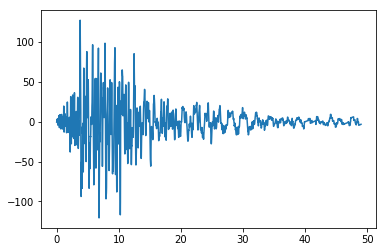

In [12]:
plt.plot(t,a)
print(acc)

In [13]:
# Heaviside step function
H_array = np.zeros(len(acc))
for i in range(len(acc)):
    if (np.abs(acc[i]) < 5):
            H = 0
            H_array[i] = H
    else:
            H = 1
            H_array[i] = H
print(H_array)

[0. 0. 0. ... 0. 0. 0.]


In [14]:
# CAV5
npts = len(acc)
t = np.linspace(0, (npts)*dt, npts)
filter = H_array
filt_acc = np.multiply(acc, filter)
CAV5 = integrate.cumtrapz(np.abs(filt_acc), dx=dt)
print(CAV5)

[  0.        0.        0.      ... 564.91094 564.91094 564.91094]


In [94]:
absolute = np.abs(acc)
for i in range(len(absolute)):
    if absolute[i] < 2.5:
        print('yes')
    else:
        print('no')

yes
yes
yes
yes
yes
no
no
yes
yes
no
yes
yes
yes
no
no
no
no
no
no
yes
yes
no
no
no
yes
no
no
no
no
no
yes
yes
no
no
no
no
no
no
yes
no
no
yes
yes
no
yes
no
no
no
no
no
no
yes
no
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
no
no
no
yes
yes
no
yes
no
no
no
no
yes
no
no
no
no
no
no
yes
no
no
no
no
yes
no
no
no
no
no
yes
no
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
yes
no
no
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
yes
yes
yes
no
no
no
no
yes
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
no
no
no
no
no
no
no
no
no
yes
no
no
no
no
no
yes
no
no
no
no
no
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
yes
no
yes
yes
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no

In [85]:
print(channel)

H1
